# FPH annual report probability visualisation
This notebook loads Fisher & Paykel Healthcare (FPH) annual report BERT outputs (finance, social, env, maori probabilities), combines them with a year column, and plots trends of how often each label is predicted strongly at three thresholds: >0.5, >0.75, >0.95.


In [25]:
# One-time install of plotting libraries (uncomment if needed)
%pip install -q matplotlib seaborn



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 120)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 10)

CODE_PREFIX = "FSF"

data_dir = Path("FSFdata")
csv_paths = sorted(data_dir.glob(f"preds-FSF*.csv"))
page_counts_path = Path("outputs/page_counts.csv")

csv_paths


[PosixPath('FSFdata/preds-FSF2013.csv'),
 PosixPath('FSFdata/preds-FSF2014.csv'),
 PosixPath('FSFdata/preds-FSF2015.csv'),
 PosixPath('FSFdata/preds-FSF2016.csv'),
 PosixPath('FSFdata/preds-FSF2017.csv'),
 PosixPath('FSFdata/preds-FSF2018.csv'),
 PosixPath('FSFdata/preds-FSF2019.csv'),
 PosixPath('FSFdata/preds-FSF2020.csv'),
 PosixPath('FSFdata/preds-FSF2021.csv'),
 PosixPath('FSFdata/preds-FSF2022.csv'),
 PosixPath('FSFdata/preds-FSF2023.csv'),
 PosixPath('FSFdata/preds-FSF2024.csv')]

In [27]:
# Load all yearly CSVs and attach a year column from the filename
def load_yearly(paths):
    if not paths:
        raise FileNotFoundError(f"No CSVs found for pattern preds-{CODE_PREFIX}*.csv in {data_dir}")
    frames = []
    for path in paths:
        year = int(path.stem.replace(f"preds-{CODE_PREFIX}", ""))
        df = pd.read_csv(path)
        df["year"] = year
        df["word_count"] = df["sentence"].fillna("").str.split().str.len()
        frames.append(df)
    return pd.concat(frames, ignore_index=True)


def load_page_counts(path):
    if not path.exists():
        return pd.DataFrame(columns=["year", "page_count"])
    page_counts = pd.read_csv(path)
    required_cols = {"code_year", "pages"}
    missing_cols = required_cols - set(page_counts.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in page counts file: {missing_cols}")
    page_counts = page_counts[page_counts["code_year"].astype(str).str.startswith(CODE_PREFIX)]
    if page_counts.empty:
        return pd.DataFrame(columns=["year", "page_count"])
    page_counts["year"] = page_counts["code_year"].str.extract(r"(\d{4})").astype(int)
    page_counts = page_counts[["year", "pages"]].rename(columns={"pages": "page_count"})
    return page_counts

# Run scripts/page_counts.py to generate outputs/page_counts.csv from PDFs in reports/
page_counts = load_page_counts(page_counts_path)

df = load_yearly(csv_paths)
df.head()


sentence  \
0                                                            THE FIRST YEAR ANNUAL REPORT 2013 FONTERRA SHAREHOLDERS’ FUND   
1  FONTERRA SHAREHOLDERS’ FUND 1 chairman’s report Dear Investors, It is my pleasure to present the first Fonterra Shar...   
2              The Fund offers investors a unique opportunity to invest in the performance of Fonterra Co-operative Group.   
3  It continues to be well supported by both institutional and retail investors, which reflects the level of interest a...   
4  Since the return on a Unit is driven by the underlying performance of Fonterra, investors are encouraged to read Fon...   

   source_page source_pdf  prob_fin_label  prob_soc_label  prob_env_label  \
0            1    FSF2013        0.006224        0.770369        0.079025   
1            3    FSF2013        0.967224        0.055765        0.001305   
2            3    FSF2013        0.997449        0.007888        0.001957   
3            3    FSF2013        0.999612        0.003043        0.003244   
4            3    FSF2013        0.999268        0.002139        0.004184   

   prob_maori_label  year  word_count  
0          0.000174  2013           9  
1          0.000667  2013          39  
2          0.002089  2013          16  
3          0.003695  2013          40  
4          0.002599  2013          49

In [28]:
# Quick data health check
prob_cols = ["prob_fin_label", "prob_soc_label", "prob_env_label", "prob_maori_label"]
display(df[["year"] + prob_cols].describe(include="all"))


year  prob_fin_label  prob_soc_label  prob_env_label  \
count  4181.000000     4181.000000     4181.000000     4181.000000   
mean   2018.723989        0.375162        0.384901        0.208967   
std       3.544707        0.441328        0.438523        0.353078   
min    2013.000000        0.000554        0.000142        0.000169   
25%    2015.000000        0.004198        0.002661        0.002959   
50%    2019.000000        0.046086        0.056254        0.008945   
75%    2022.000000        0.955751        0.959244        0.201632   
max    2024.000000        0.999630        0.999094        0.999335   

       prob_maori_label  
count       4181.000000  
mean           0.007149  
std            0.072612  
min            0.000062  
25%            0.000695  
50%            0.001324  
75%            0.002094  
max            0.999161

In [29]:
# Reshape to long format for easier analysis across labels
long_df = df.melt(
    id_vars=["year", "word_count"],
    value_vars=prob_cols,
    var_name="label",
    value_name="probability"
)
long_df["label"] = long_df["label"].str.replace("prob_", "").str.replace("_label", "").str.upper()
long_df.head()


year  word_count label  probability
0  2013           9   FIN     0.006224
1  2013          39   FIN     0.967224
2  2013          16   FIN     0.997449
3  2013          40   FIN     0.999612
4  2013          49   FIN     0.999268

In [30]:
# Helpers to summarize and plot strong predictions at arbitrary thresholds
BASE_YEAR = 2018

def summarize_over_threshold(df_long, threshold):
    over_mask = df_long["probability"] > threshold
    enriched = df_long.assign(
        over=over_mask,
        over_word_count=lambda d: d["word_count"].where(over_mask, 0)
    )

    agg = (
        enriched
        .groupby(["year", "label"])
        .agg(
            total_sentences=("probability", "size"),
            total_words=("word_count", "sum"),
            over_count=("over", "sum"),
            over_share=("over", "mean"),  # same as count/total sentences
            over_word_count=("over_word_count", "sum"),
            mean_prob_over=("probability", lambda s: s[s > threshold].mean() if (s > threshold).any() else 0.0),
            sum_prob_over=("probability", lambda s: s[s > threshold].sum()),
        )
        .reset_index()
    )
    agg = agg.merge(page_counts, on="year", how="left")
    agg["page_count"] = agg["page_count"].replace({0: pd.NA})
    agg["over_sentence_word_share"] = agg["over_count"] / agg["total_words"]
    agg["over_word_share"] = agg["over_word_count"] / agg["total_words"]
    agg["sentences_per_page"] = agg["total_sentences"] / agg["page_count"]
    agg["over_sentences_per_page"] = agg["over_count"] / agg["page_count"]
    agg["over_words_per_page"] = agg["over_word_count"] / agg["page_count"]
    agg["theme_rate_per_1000_words"] = np.where(
        agg["total_words"] > 0,
        (agg["over_count"] / agg["total_words"]) * 1000,
        0.0,
    )
    non_theme = agg["total_sentences"] - agg["over_count"]
    agg["theme_ratio_per_1000_sentences"] = np.where(
        non_theme > 0,
        (agg["over_count"] / non_theme) * 1000,
        0.0,
    )
    base_counts = agg["label"].map(
        agg.loc[agg["year"] == BASE_YEAR, ["label", "over_count"]]
        .drop_duplicates(subset=["label"])
        .set_index("label")["over_count"]
    )
    agg["theme_index_base"] = np.where(
        base_counts > 0,
        (agg["over_count"] / base_counts) * 100,
        0.0,
    )
    agg["avg_theme_score_relevant"] = agg["mean_prob_over"]
    agg["threshold"] = threshold
    return agg


thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
summaries = {thr: summarize_over_threshold(long_df, thr) for thr in thresholds}

# Quick peek at the first threshold summary
preview_threshold = thresholds[0]
summaries[preview_threshold].head()


year  label  total_sentences  total_words  over_count  over_share  \
0  2013    ENV              348        10001          48    0.137931   
1  2013    FIN              348        10001         137    0.393678   
2  2013  MAORI              348        10001           2    0.005747   
3  2013    SOC              348        10001         111    0.318966   
4  2014    ENV              360         9808          58    0.161111   

   over_word_count  mean_prob_over  sum_prob_over  page_count  \
0             1323        0.931336      44.704139          28   
1             4482        0.959392     131.436767          28   
2               37        0.994316       1.988633          28   
3             2770        0.950469     105.502071          28   
4             1900        0.946439      54.893470          28   

   over_sentence_word_share  over_word_share  sentences_per_page  \
0                  0.004800         0.132287           12.428571   
1                  0.013699         0.448155           12.428571   
2                  0.000200         0.003700           12.428571   
3                  0.011099         0.276972           12.428571   
4                  0.005914         0.193719           12.857143   

   over_sentences_per_page  over_words_per_page  theme_rate_per_1000_words  \
0                 1.714286            47.250000                    4.79952   
1                 4.892857           160.071429                   13.69863   
2                 0.071429             1.321429                    0.19998   
3                 3.964286            98.928571                   11.09889   
4                 2.071429            67.857143                    5.91354   

   theme_ratio_per_1000_sentences  theme_index_base  avg_theme_score_relevant  \
0                      160.000000        111.627907                  0.931336   
1                      649.289100        123.423423                  0.959392   
2                        5.780347        200.000000                  0.994316   
3                      468.354430        103.738318                  0.950469   
4                      192.052980        134.883721                  0.946439   

   threshold  
0        0.7  
1        0.7  
2        0.7  
3        0.7  
4        0.7

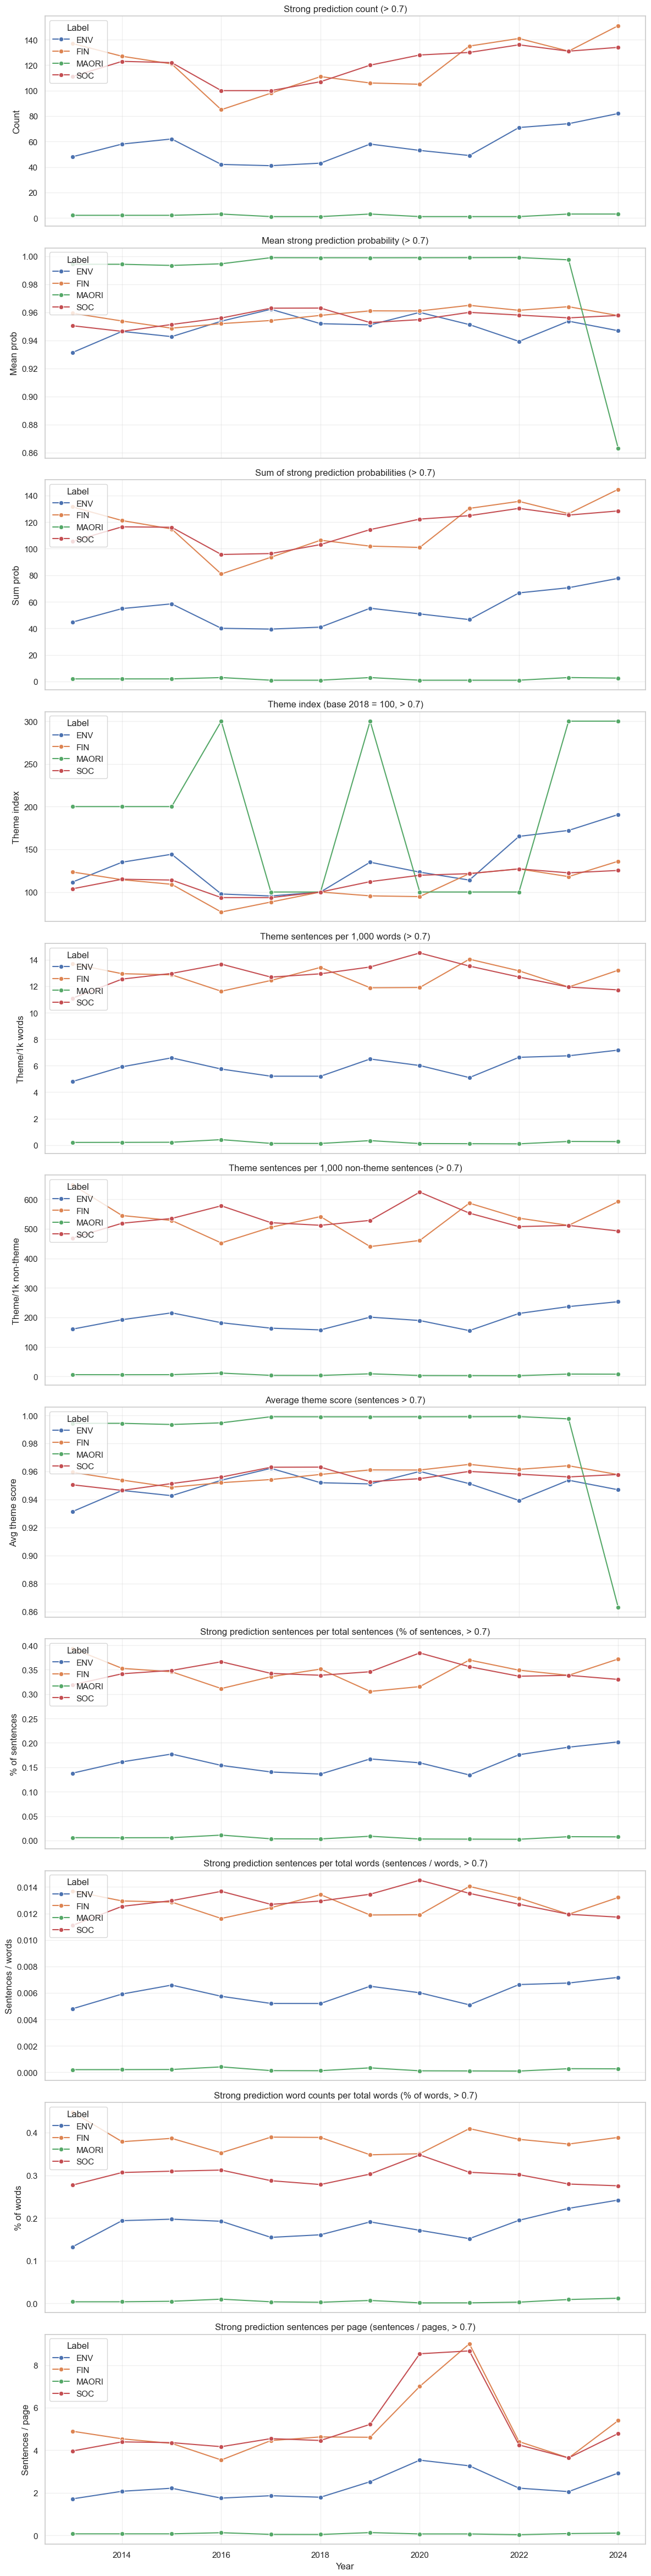

In [31]:
# Combined view for threshold > 0.7 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.7)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.7)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.7)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.7)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.7)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.7)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.7)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.7)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.7)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.7)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.7)"),
]
summary = summaries[0.7]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


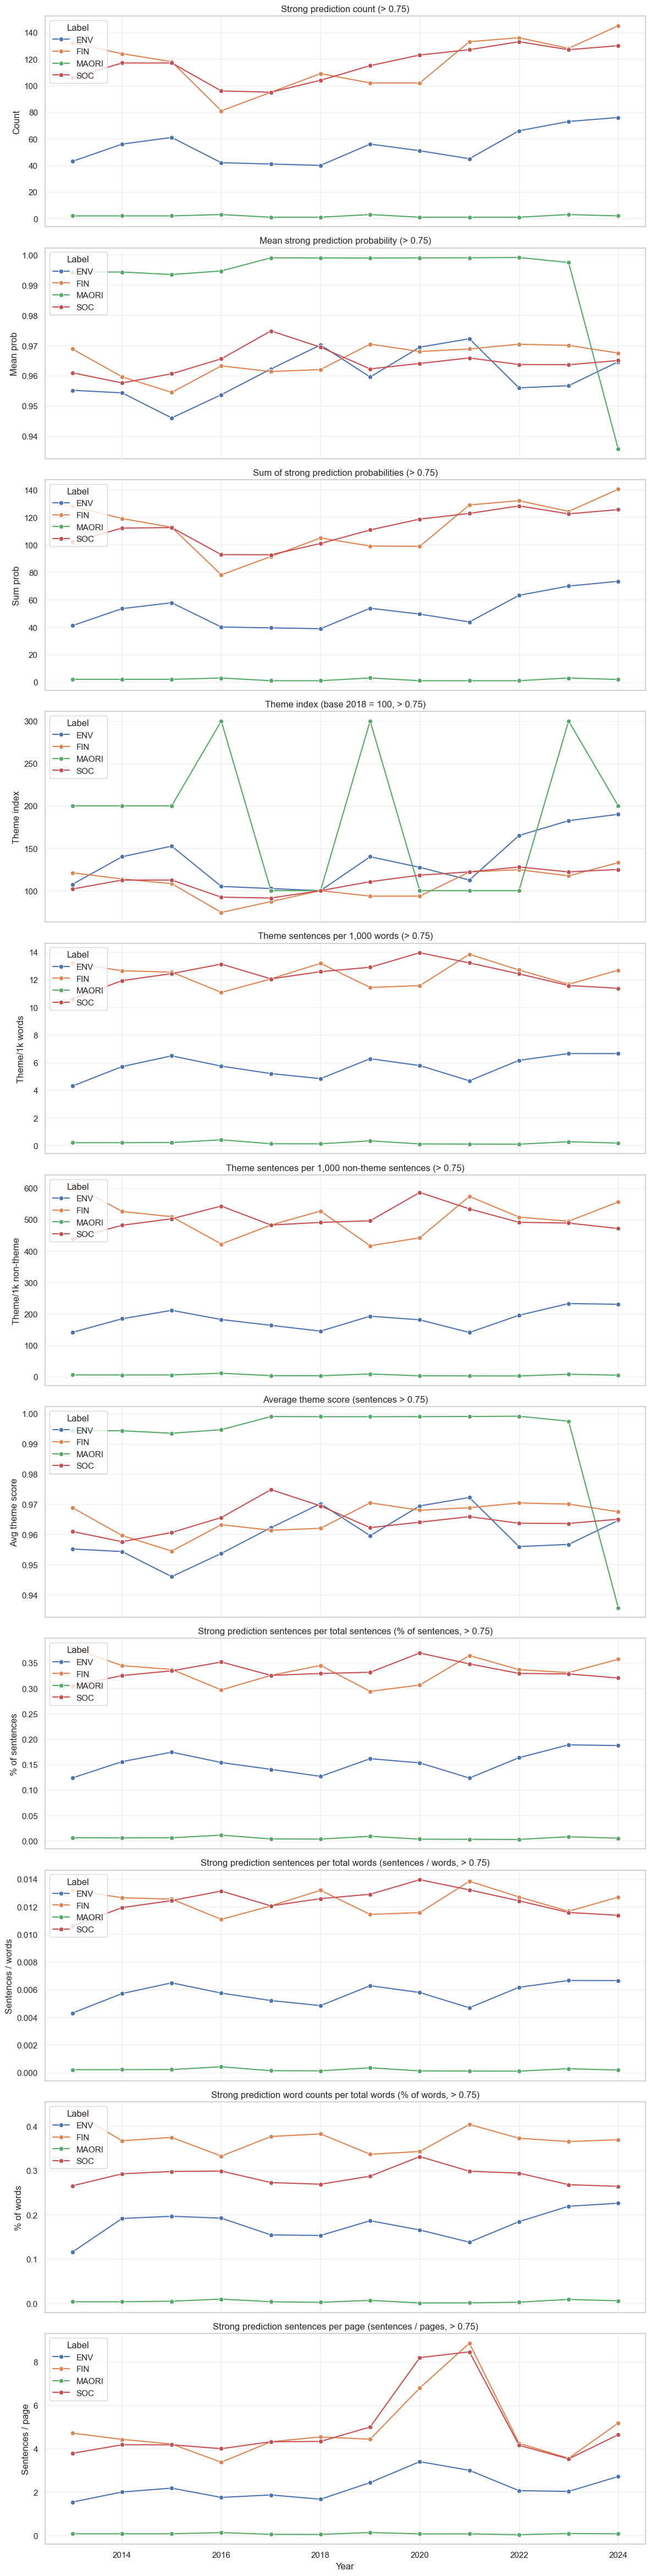

In [32]:
# Combined view for threshold > 0.75 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.75)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.75)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.75)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.75)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.75)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.75)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.75)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.75)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.75)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.75)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.75)"),
]
summary = summaries[0.75]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


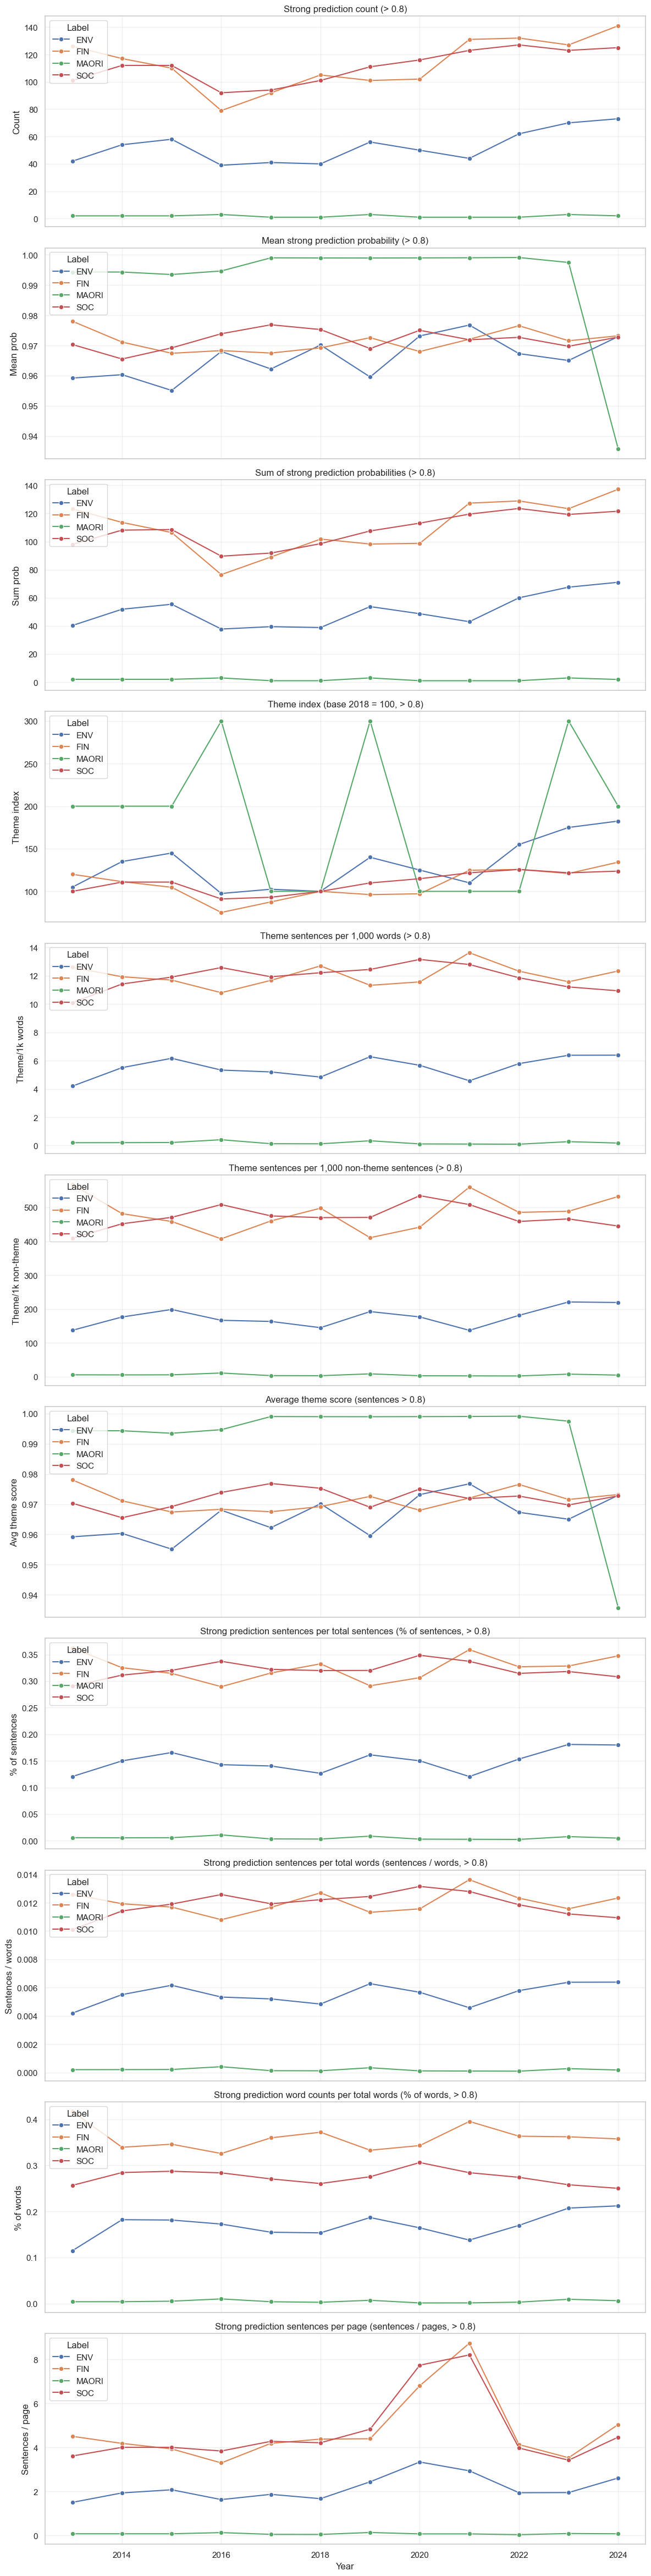

In [33]:
# Combined view for threshold > 0.8 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.8)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.8)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.8)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.8)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.8)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.8)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.8)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.8)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.8)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.8)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.8)"),
]
summary = summaries[0.8]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


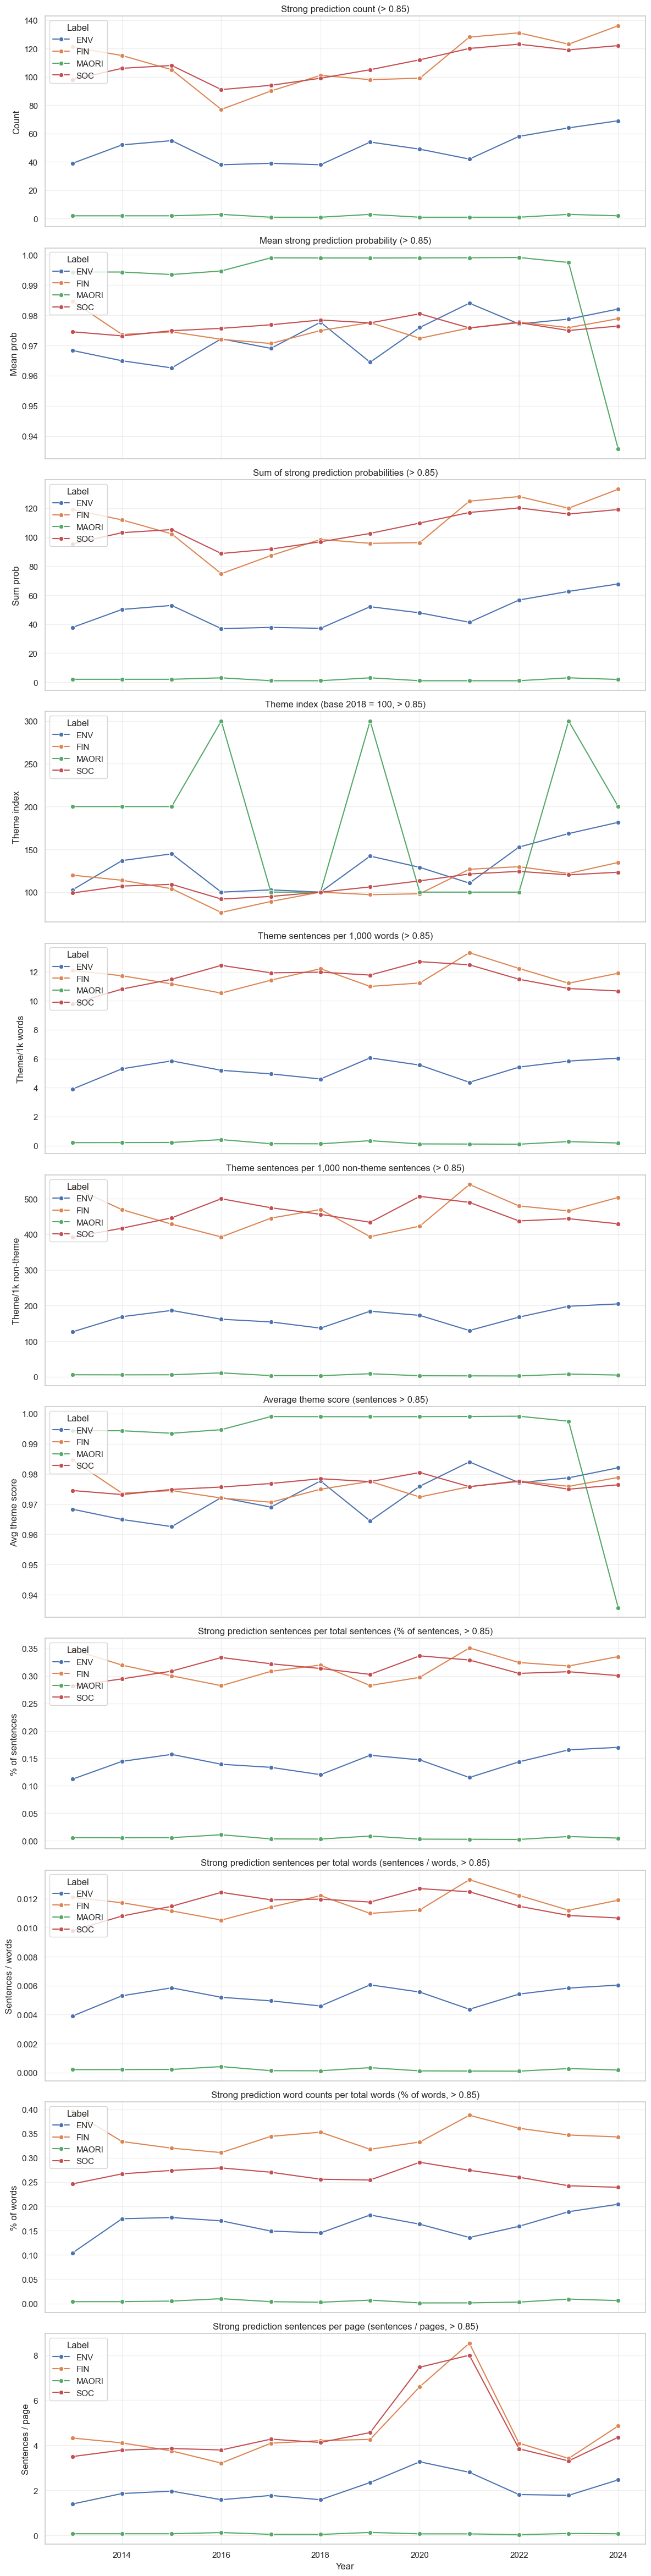

In [34]:
# Combined view for threshold > 0.85 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.85)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.85)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.85)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.85)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.85)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.85)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.85)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.85)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.85)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.85)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.85)"),
]
summary = summaries[0.85]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


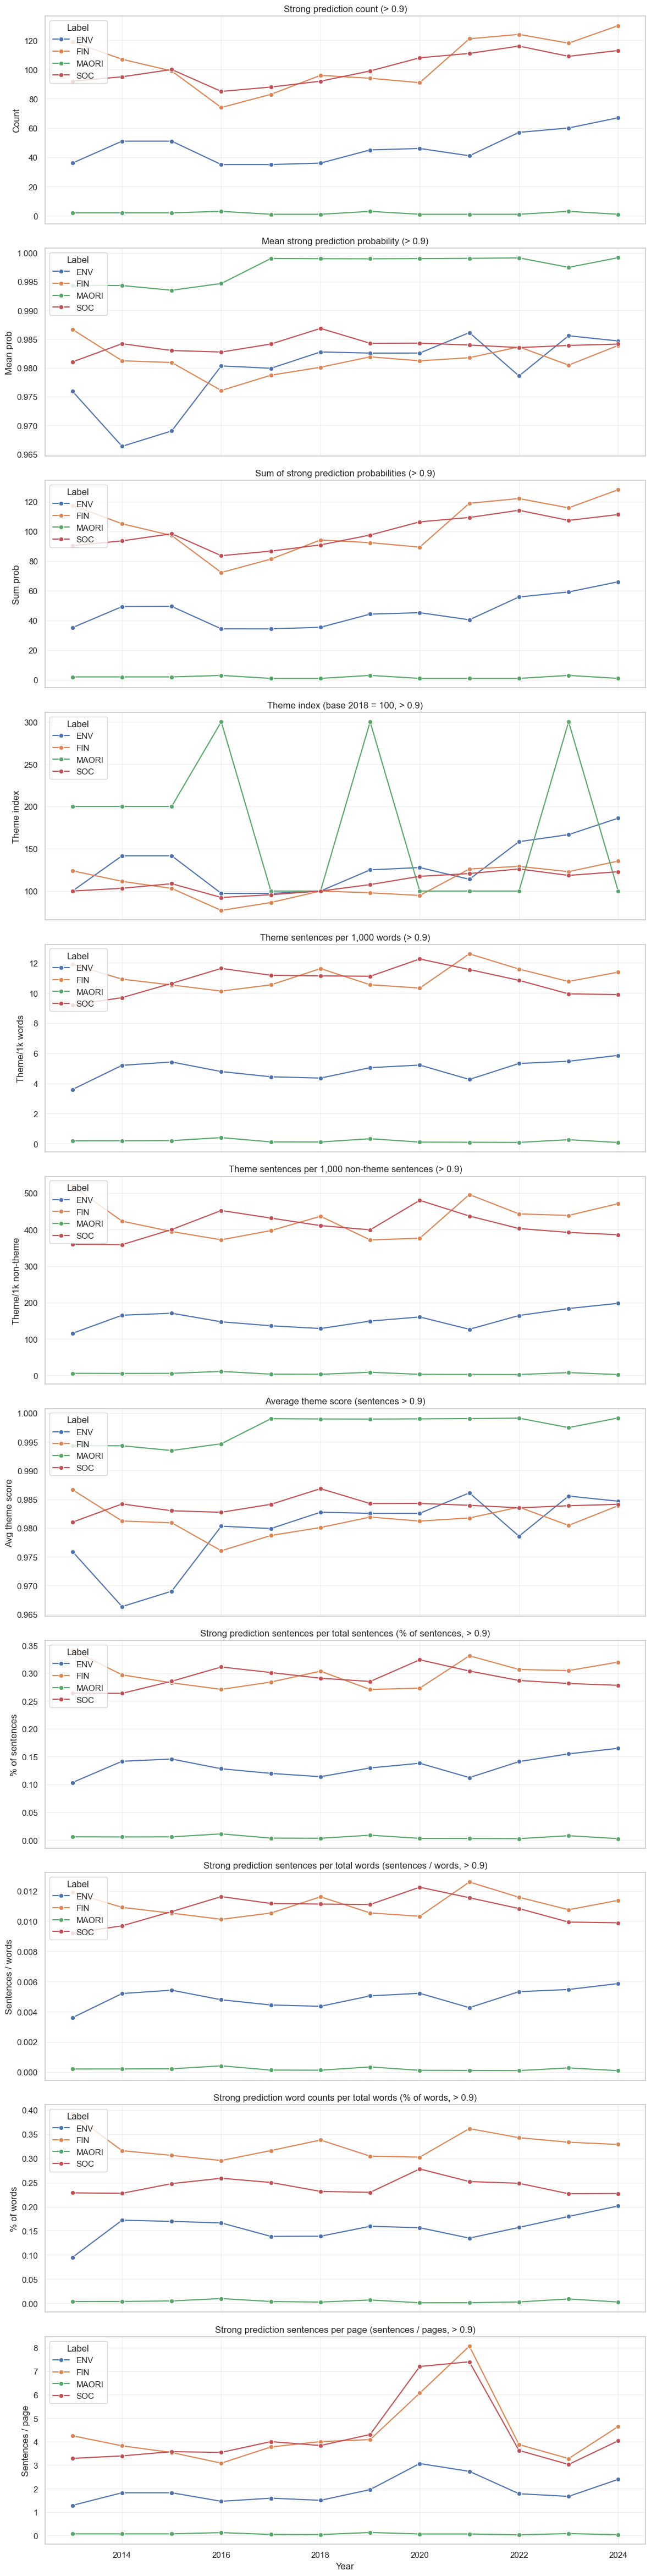

In [35]:
# Combined view for threshold > 0.9 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.9)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.9)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.9)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.9)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.9)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.9)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.9)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.9)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.9)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.9)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.9)"),
]
summary = summaries[0.9]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


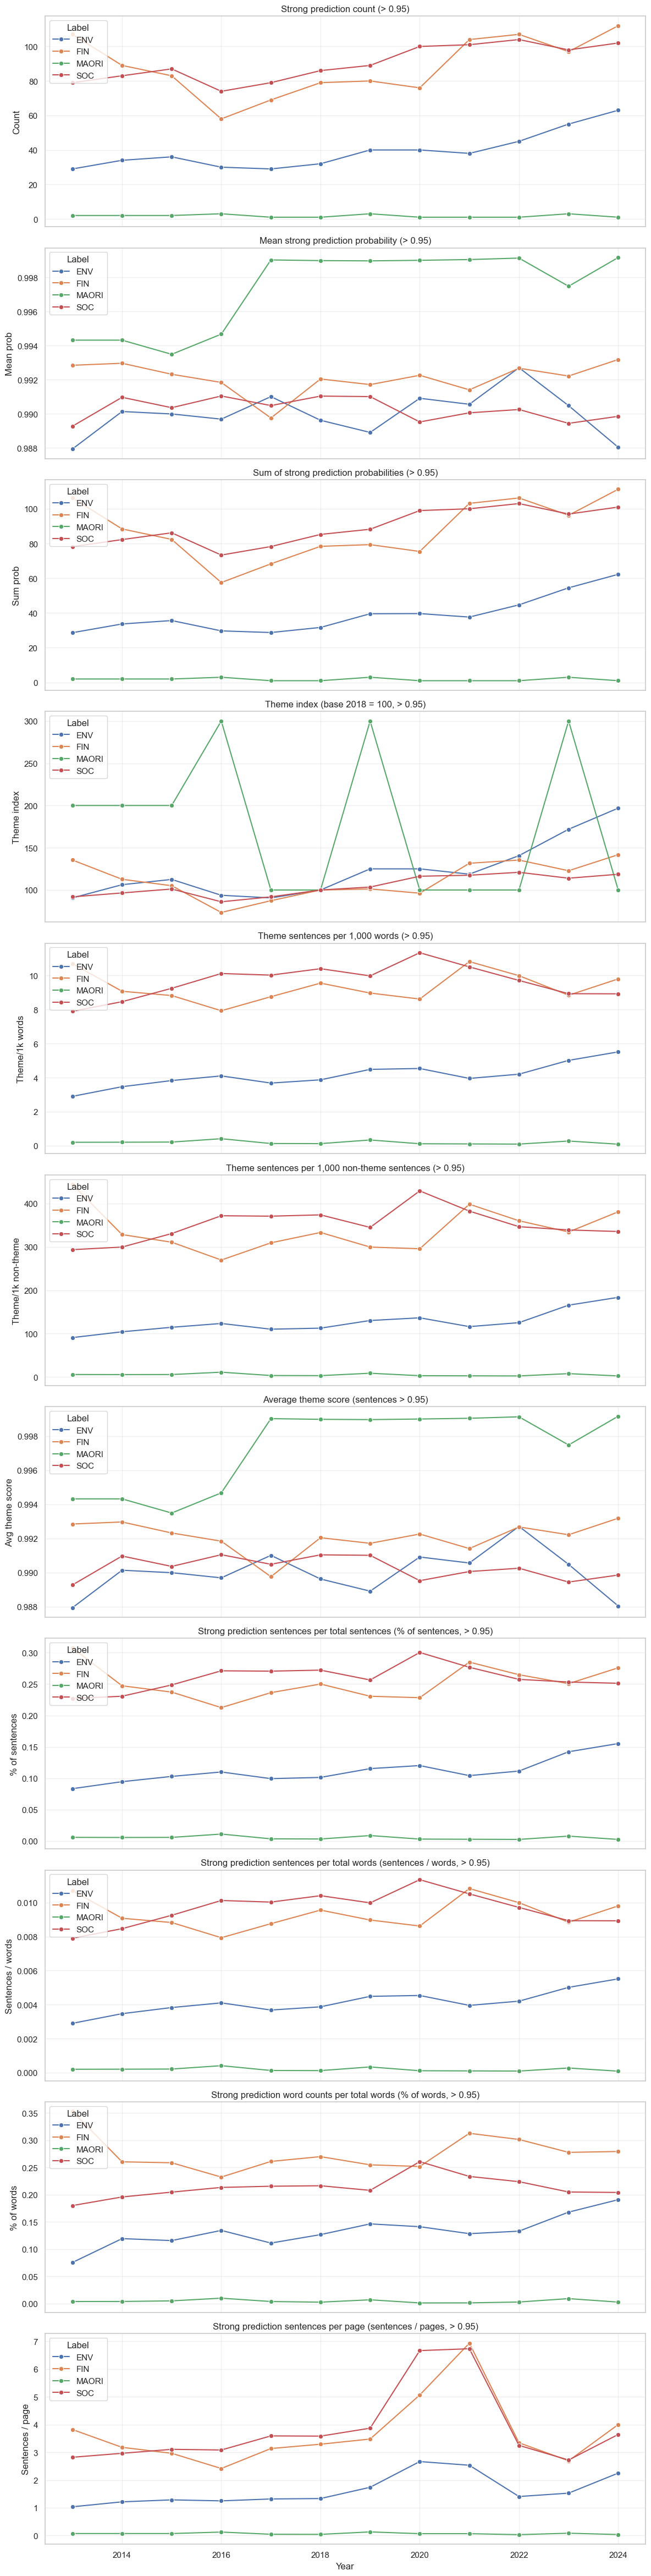

In [36]:
# Combined view for threshold > 0.95 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.95)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.95)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.95)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.95)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.95)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.95)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.95)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.95)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.95)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.95)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.95)"),
]
summary = summaries[0.95]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


Notes
- over_count: how many sentences per label per year with predicted probability above the chosen threshold.
- over_share: same as over_count / total sentences for that year+label (proportion of strong predictions).
- over_sentence_word_share: strong prediction sentences divided by total words in that year+label grouping.
- over_word_share: total words from strong prediction sentences divided by total words for that year+label grouping.
- over_sentences_per_page: strong prediction sentences divided by page count for that year (requires outputs/page_counts.csv).
- over_words_per_page: total words from strong prediction sentences divided by page count for that year (requires outputs/page_counts.csv).
- mean_prob_over: average probability for those sentences above the threshold (NaN if none above threshold).
